# Question 3_b

Name = Maryam Karimi Jafari

Student ID = 99106617

# Setup

In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import keras
from imutils import paths
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image
from keras.utils import to_categorical
from keras import regularizers, layers


# Loading Data

creating a pandas dataframe from videos file path and their coresponding labels.

In [4]:
dataset_train_path = '/content/drive/MyDrive/SCR_HW3_Q4_LipReading/train'
dataset_test_path = '/content/drive/MyDrive/SCR_HW3_Q4_LipReading/test'

In [5]:
def create_dataframe_from_videos_name(folder_path):
    """
    Reads video file names from the given folder, extracts labels, and stores
    the file paths and labels in a pandas DataFrame.

    Args:
        folder_path (str): Path to the folder containing video files.

    Returns:
        pd.DataFrame: DataFrame with columns ['file_path', 'label'].
    """
    file_paths = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.mp4'):
            file_path = os.path.join(folder_path, filename)
            label = filename.split('w')[1].split('-')[0]
            file_paths.append(file_path)
            labels.append(label)

    data = {'file_path': file_paths, 'label': labels}
    df = pd.DataFrame(data)

    return df

In [6]:
train_df = create_dataframe_from_videos_name(dataset_train_path)
test_df = create_dataframe_from_videos_name(dataset_test_path)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 160
Total videos for testing: 40


,file_path,label
144,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,3
146,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,3
74,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
19,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,2
56,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,2
55,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
7,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,3
68,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,4
115,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
47,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,3


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Define hyperparameters

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 250

MAX_SEQ_LENGTH = 30
# number of features is the CNN's output size
NUM_FEATURES = 2048

# Data preparation

In [8]:
# function for loading a video and making the frames
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

using the CNN Inception model as feature extractor.

In [9]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


printing the labels and converting them to one hot encoding.

In [10]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

['1', '2', '3', '4', '5']


In [11]:
classes = to_categorical([int(i) for i in np.unique(train_df["label"])])
print(classes)

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


## actually loading the data

In [12]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["file_path"].values.tolist()
    labels = df["label"].values
    labels = to_categorical(keras.ops.convert_to_numpy(label_processor(labels[..., None])))

    #`frame_features` are what we will feed to our transformer model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in test set: {test_data.shape}")

Frame features in train set: (160, 30, 2048)
Frame features in test set: (40, 30, 2048)


# building the model and training+evaluating

## training

In [30]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "output_dim": self.output_dim
        })
        return config

In [31]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation='relu'),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

In [32]:
def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 8
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.summary()

    sch = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                  decay_steps=100000,
                                                  decay_rate=0.9)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=sch),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [42]:
def run_experiment():
    filepath = "/content/drive/MyDrive/video_classifier_CNN_Transformer/HW3_3_b_16.keras"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, monitor='val_accuracy', save_best_only=True, verbose=1
    )
    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint],
    )

    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [43]:
history, transformer_model = run_experiment()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 30, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ frame_position_embedding             │ (None, 30, 2048)            │          61,440 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_layer                    │ (None, 30, 2048)            │      16,828,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 2048)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │          10,245 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,900,109 (64.47 MB)

 Trainable params: 16,900,109 (64.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1797 - loss: 4.5392
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/video_classifier_CNN_Transformer/HW3_3_b_16.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1797 - loss: 4.5392 - val_accuracy: 0.2500 - val_loss: 16.5283
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.2344 - loss: 13.1550
Epoch 2: val_accuracy did not improve from 0.25000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2344 - loss: 13.1550 - val_accuracy: 0.1250 - val_loss: 22.7671
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.2188 - loss: 17.9909
Epoch 3: val_accuracy did not improve from 0.25000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2188 - loss: 17.9909 - val_accuracy: 0.1250 - val_loss: 12.1270
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2422 - loss: 9.5148
Epoch 4: val_accuracy did not improve from 0.25000
1/1 ━━━━━━━━━━━━━━━

result for evaluating => test accuracy = 80%

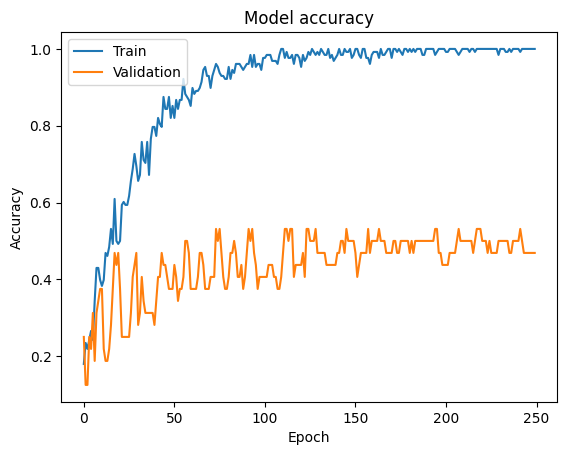

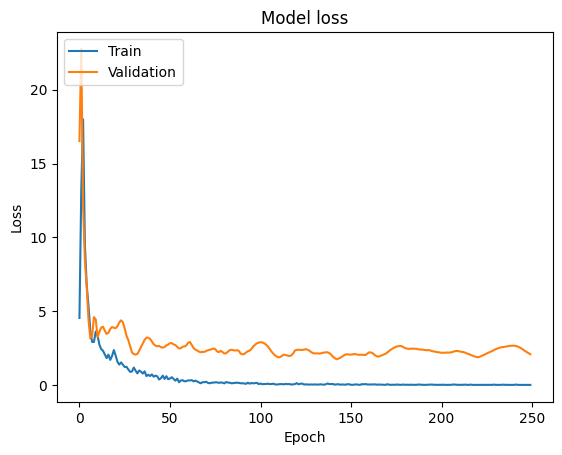

In [44]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## testing the result on a single random video

the result is 100% for class 5 which is right.

Test video path: /content/drive/MyDrive/SCR_HW3_Q4_LipReading/test/s9-w5-r3.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━

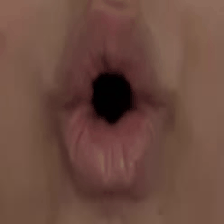

In [45]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])

    return frame_features


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = transformer_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["file_path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [46]:
transformer_model.save('/content/drive/MyDrive/video_classifier_CNN_Transformer/HW3_3_b_16.h5')

## confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


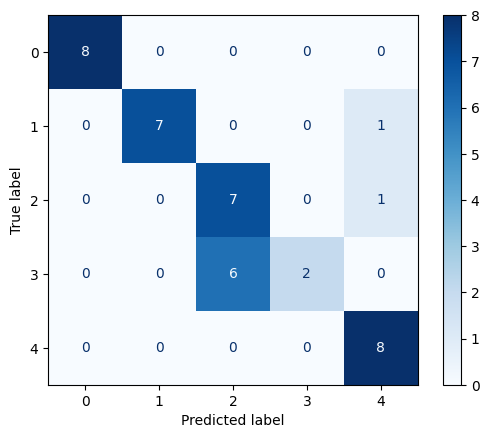

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = test_labels
y_pred = transformer_model.predict(test_data)

labels = classes
y_pred_plot=np.argmax(y_pred, axis=1)
y_test_plot=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_plot, y_pred_plot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## model architecture

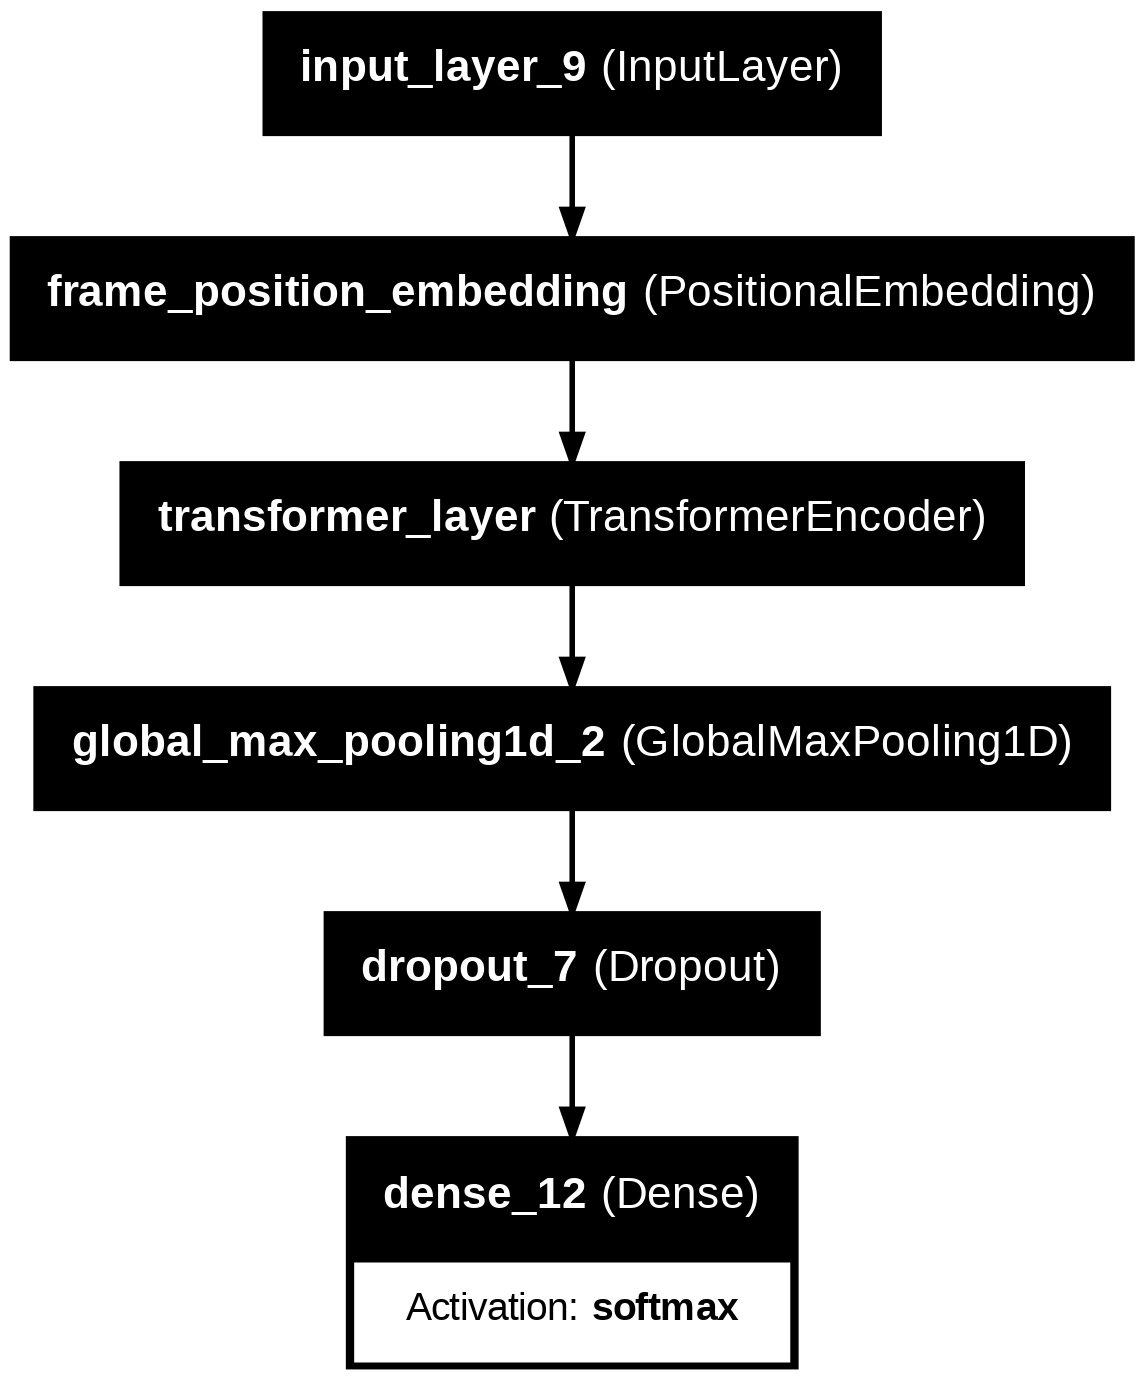

In [48]:
keras.utils.plot_model(transformer_model, show_layer_activations=True, show_layer_names=True)

# loading and evaluating the best model

model link = https://drive.google.com/file/d/1-GeWk1oIjWlyu1mrPu0WP6yt0O7rpkh0/view?usp=sharing

best model name = HW3_3_b_16.h5

In [49]:
# Register the custom layers
custom_objects = {
    'PositionalEmbedding': PositionalEmbedding,
    'TransformerEncoder': TransformerEncoder
}

from keras.models import load_model
model = load_model('/content/drive/MyDrive/video_classifier_CNN_Transformer/HW3_3_b_16.h5', custom_objects=custom_objects)

_, accuracy = model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - accuracy: 0.7937 - loss: 3.1537
Test accuracy: 80.0%


# comparing CNN_RNN and CNN_Transformer

this model has the same feature extractor as the CNN model. but in comparison with the previous model, it has really large number of parameters and it takes a bit longer to train. this transformer model also looks a more stable model, the tran and validation loss goes to zero at the end.

# references

https://www.tensorflow.org/tutorials/load_data/video#create_frames_from_each_video_file

https://www.tensorflow.org/tutorials/video/video_classification

https://keras.io/examples/vision/video_classification/

https://keras.io/api/applications/inceptionv3/

https://medium.com/@gcagrici/video-classification-with-deep-learning-3840b20b7949

https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5

https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_classification.ipynb#scrollTo=trmOK6x6ipyU

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_transformers.ipynb



